# This is the first version of building a Bayesian Network for risk management

In [5]:
#----------------------------------
# Try to build the BNs
#----------------------------------
import numpy as np
import pandas as pd


from pgmpy.base import DAG
from pgmpy.models import FunctionalBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.factors.hybrid import FunctionalCPD
import pyro.distributions as dist


from pgmpy.models import BayesianNetwork
from pgmpy.sampling import GibbsSampling, BayesianModelSampling
from pgmpy.inference import VariableElimination


import matplotlib.pyplot as plt
from IPython.display import Image


## The BN built with my thoughts

In [5]:
BN_risk = DAG()
BN_risk.add_nodes_from(nodes=['Building type', 'The type of roof', 'Height', 'Geometry data', 'The number of storey'])
BN_risk.add_edges_from(ebunch=[('Building type', 'Activation risk'),
                               ('Activation risk', 'The probability of fire occurance'),
                               ('The probability of fire occurance', 'The number of deaths')])
BN_risk.add_edges_from(ebunch=[('Geometry data', 'Area'),
                               ('Area', 'Volume'),
                               ('Height', 'Volume'),
                               ('The type of roof', 'Volume'),
                               ('Volume', 'The probability of fire occurance')])
BN_risk.add_edges_from(ebunch=[('Volume', 'The number of people'),
                               ('Height', 'The number of people'),
                               ('The number of storey', 'The number of people'),
                               ('Building type', 'The number of people'),
                               ('The number of people', 'The number of deaths')])
BN_risk.add_edges_from(ebunch=[('The probability of death', 'The number of deaths')])



/Users/chupei/Desktop/Test/.venv/lib/python3.13/site-packages/pygraphviz/agraph.py:1403: RuntimeWarning: Warning: using box for unknown shape rhomboid

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


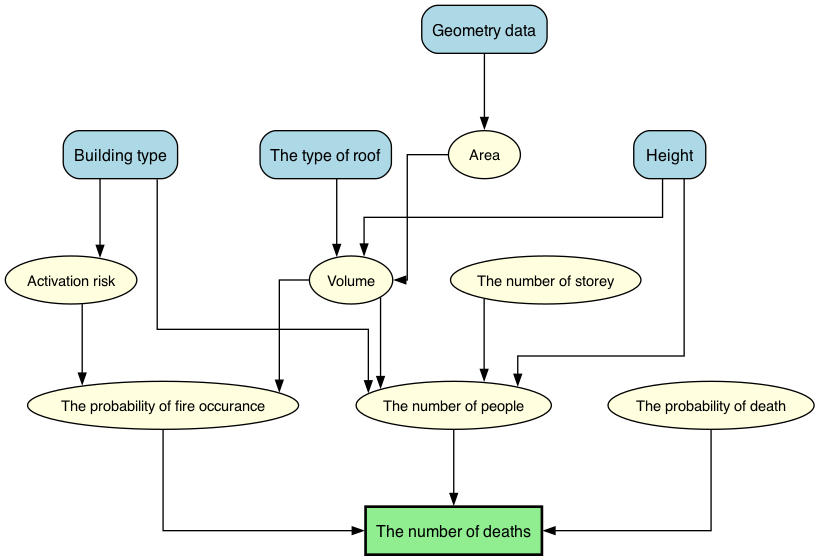

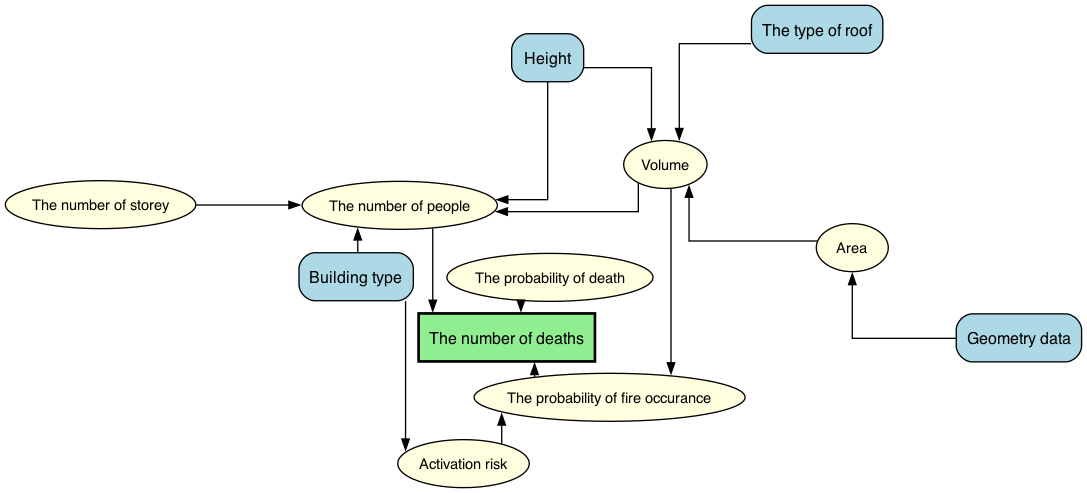

/Users/chupei/Desktop/Test/.venv/lib/python3.13/site-packages/pygraphviz/agraph.py:1403: RuntimeWarning: Warning: using box for unknown shape rhomboid

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


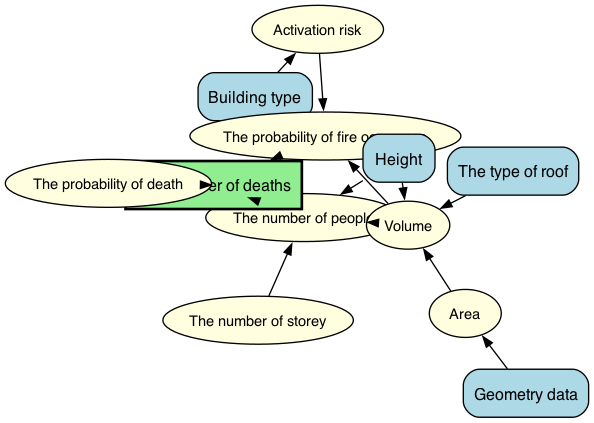

In [6]:
try:
    # Create visualization with custom attributes
    viz = BN_risk.to_graphviz()
    
    # Define input and output nodes
    input_nodes = ['Building type', 'The type of roof', 'Height', 'Geometry data', 'The number of storeys']
                   
    output_nodes = ['The number of deaths']


    # Customize overall graph appearance
    viz.graph_attr.update({
        'rankdir': 'TB',        # top to bottom layout
        'splines': 'ortho',
        'nodesep': '0.6',
        'ranksep': '0.8'
    })

    # Default node attributes
    viz.node_attr.update({
        'shape': 'ellipse',     # default for causal nodes
        'style': 'filled',
        'fillcolor': 'lightyellow',
        'fontname': 'Helvetica',
        'fontsize': '11'
    })

    # Customize specific node types
    for node in BN_risk.nodes():
        if node in output_nodes:
            viz.get_node(node).attr.update({
                'shape': 'rhomboid',
                'fillcolor': 'lightgreen',
                'style': 'filled,bold',
                'fontsize': '12'
            })
        elif node in input_nodes:
            viz.get_node(node).attr.update({
                'shape': 'rectangle',
                'fillcolor': 'lightblue',
                'style': 'filled,rounded',
                'fontsize': '12'
            })
        else:
            # Causal (intermediate) nodes
            viz.get_node(node).attr.update({
                'shape': 'ellipse',
                'fillcolor': 'lightyellow',
                'style': 'filled',
                'fontsize': '11'
            })

    # Customize edges
    viz.edge_attr.update({
        'arrowsize': '0.8',
        'penwidth': '1.0'
    })

    
    
    
    
    # Generate layouts
    layouts = ['dot', 'fdp', 'neato']
    for layout in layouts:
        viz.draw(f'model_{layout}.png', prog=layout)
        display(Image(f'model_{layout}.png'))
        
except ImportError:
    print("Please install required packages:")
    print("brew install graphviz")
    print("pip install pygraphviz")

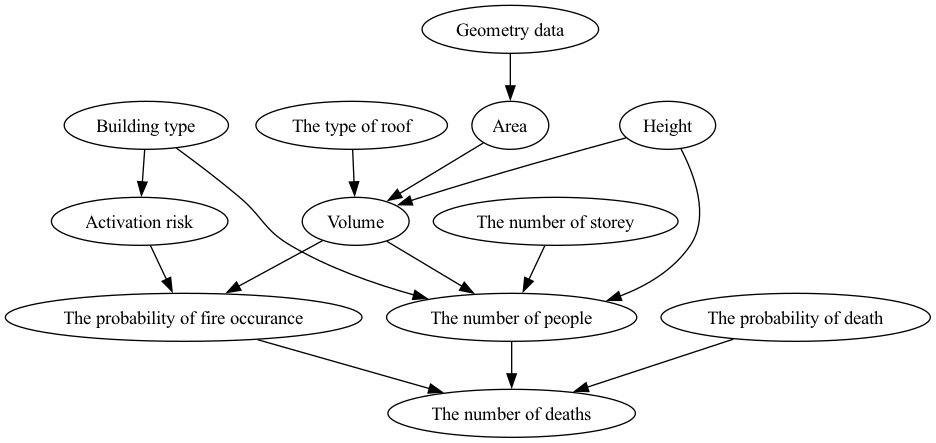

In [7]:
viz = BN_risk.to_graphviz()
viz.draw('model.png', prog='dot')
Image('model.png')

## The simple BN for testing

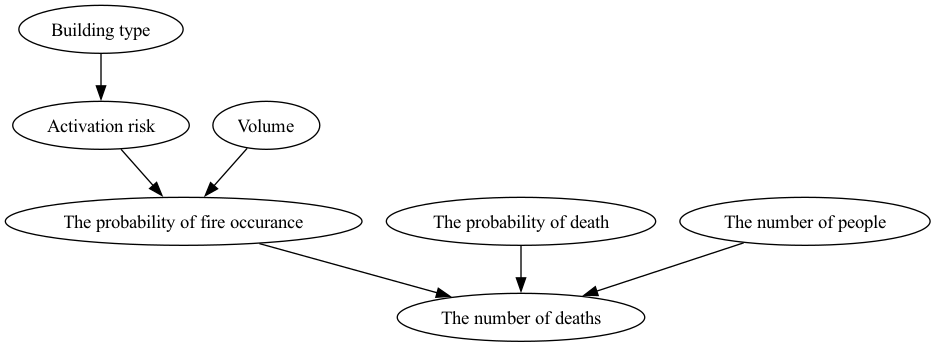

In [3]:
BN_risk = DAG()
BN_risk.add_nodes_from(nodes=['Building type'])
BN_risk.add_edges_from(ebunch=[('Building type', 'Activation risk')])
BN_risk.add_edges_from(ebunch=[('Volume', 'The probability of fire occurance'),
                               ('Activation risk', 'The probability of fire occurance')])
BN_risk.add_edges_from(ebunch=[('The probability of fire occurance', 'The number of deaths'),
                               ('The probability of death', 'The number of deaths'),
                               ('The number of people', 'The number of deaths')])

# The expected numebr of deaths is just an risk indicator
viz = BN_risk.to_graphviz()
viz.draw('model.png', prog='dot')
Image('model.png')

### The Discrete BN model

Flexibility: Change BUILDING_TYPE (0, 1, or 2) to analyze different risk scenarios<br/>
Accuracy: Quantile-based binning ensures all probability bins are meaningful<br/>
Efficiency: Discrete BN allows fast exact inference with Variable Elimination<br/>
Interpretability: Both discrete bins and continuous value interpretations available<br/>

In [1]:
import numpy as np
import pandas as pd
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.sampling import BayesianModelSampling
from pgmpy.inference import VariableElimination
from scipy import stats
from itertools import product
import matplotlib.pyplot as plt

In [20]:
# ============================================================================
# CONFIGURATION: Change this value for different cases
# ============================================================================
BUILDING_TYPE = 1  # 0: Low Risk, 1: Middle Risk, 2: High Risk
# ============================================================================

# Building parameters (from your example)
idx_people = 44
idx_volume = 1865.1
idx_prob_death_mean = 0.0024163681936925294

# Risk factors
risk_factors_array = {
    'alpha': np.array([-9.011, -9.005, -9.422]),
    'beta':  np.array([0.434, 0.536, 0.669]),
    'gamma': np.array([0.018, 0.034, 0.030])
}

risk_level_map = {0: "Low Risk", 1: "Middle Risk", 2: "High Risk"}

print("="*70)
print(f"BUILDING CONFIGURATION: Type = {BUILDING_TYPE} ({risk_level_map[BUILDING_TYPE]})")
print("="*70)

BUILDING CONFIGURATION: Type = 1 (Middle Risk)


In [21]:
# ============================================================================
# Helper Functions
# ============================================================================

def create_deterministic_cpd(child, parents, parent_cards, func):
    """
    Create a CPD for deterministic relationships.
    
    Args:
        child: Name of child variable
        parents: List of parent variable names
        parent_cards: List of cardinalities for each parent
        func: Deterministic function that takes parent values and returns child value
    
    Returns:
        TabularCPD object
    """
    # Generate all parent combinations
    parent_combos = list(product(*[range(card) for card in parent_cards]))
    n_combos = len(parent_combos)
    
    # Calculate child cardinality
    child_vals = [func(*combo) for combo in parent_combos]
    child_card = max(child_vals) + 1
    
    # Initialize CPD table (all zeros)
    cpd_values = np.zeros((child_card, n_combos))
    
    # Fill in deterministic probabilities
    for i, parent_vals in enumerate(parent_combos):
        child_val = func(*parent_vals)
        cpd_values[child_val, i] = 1.0
    
    return TabularCPD(child, child_card, cpd_values,
                     evidence=parents, evidence_card=parent_cards)

class ContinuousToDiscreteCPD:
    """Helper class to discretize continuous distributions into TabularCPD"""
    
    def __init__(self, variable_name, n_bins, distribution, dist_params):
        """
        Args:
            variable_name: Name of the variable
            n_bins: Number of discrete bins
            distribution: scipy.stats distribution object
            dist_params: Dictionary of distribution parameters
        """
        self.variable_name = variable_name
        self.n_bins = n_bins
        self.distribution = distribution
        self.dist_params = dist_params
        
        # Calculate bins based on quantiles for better coverage
        quantiles = np.linspace(0.001, 0.999, n_bins + 1)
        self.bins = distribution.ppf(quantiles, **dist_params)
        self.bin_centers = (self.bins[:-1] + self.bins[1:]) / 2
        
    def get_probabilities(self):
        """Calculate discrete probabilities for each bin"""
        probs = []
        for i in range(self.n_bins):
            prob = (self.distribution.cdf(self.bins[i+1], **self.dist_params) - 
                   self.distribution.cdf(self.bins[i], **self.dist_params))
            probs.append(prob)
        
        # Normalize to ensure sum = 1.0
        probs = np.array(probs)
        probs = probs / probs.sum()
        return probs
    
    def discretize_value(self, continuous_value):
        """Convert a continuous value to discrete bin index"""
        return np.digitize(continuous_value, self.bins[1:-1])
    
    def get_cpd(self):
        """Create TabularCPD for this variable"""
        probs = self.get_probabilities().reshape(-1, 1)
        return TabularCPD(
            variable=self.variable_name,
            variable_card=self.n_bins,
            values=probs
        )

In [ ]:
# ============================================================================
# Step 1: Define discretized continuous variables
# ============================================================================
n_bins = 5  # Number of discrete states per variable

# People: Uniform distribution around observed value
people_disc = ContinuousToDiscreteCPD(
    variable_name='People',
    n_bins=n_bins,
    distribution=stats.uniform,
    dist_params={'loc': max(0, idx_people - 5), 'scale': 10}
)

# Volume: Normal distribution
volume_disc = ContinuousToDiscreteCPD(
    variable_name='Volume',
    n_bins=n_bins,
    distribution=stats.norm,
    dist_params={'loc': idx_volume, 'scale': 50}
)

# Probability of Death: Beta distribution
prob_death_disc = ContinuousToDiscreteCPD(
    variable_name='Prob_Death',
    n_bins=n_bins,
    distribution=stats.beta,
    dist_params={'a': 413.5, 'b': 176171.5}
)

In [11]:
# ============================================================================
# Step 2: Building Type - Deterministic constant
# ============================================================================
building_type_cpd = TabularCPD(
    variable='Building_Type',
    variable_card=3,
    values=[[1.0 if i == BUILDING_TYPE else 0.0] for i in range(3)]
)

print(f"\nBuilding Type CPD:")
print(building_type_cpd)

# ============================================================================
# Step 3: Activation Risk - Depends on Building Type with uncertainty
# ============================================================================
ar_values = np.array([
    [0.985, 0.01, 0.005],   # P(AR=0 | BT=0,1,2)
    [0.01, 0.98, 0.01],     # P(AR=1 | BT=0,1,2)
    [0.005, 0.01, 0.985]    # P(AR=2 | BT=0,1,2)
])

activation_risk_cpd = TabularCPD(
    variable='Activation_Risk',
    variable_card=3,
    values=ar_values,
    evidence=['Building_Type'],
    evidence_card=[3]
)


Building Type CPD:
+------------------+---+
| Building_Type(0) | 0 |
+------------------+---+
| Building_Type(1) | 1 |
+------------------+---+
| Building_Type(2) | 0 |
+------------------+---+


In [ ]:
# ============================================================================
# Step 4: Fire Probability - Deterministic function of Volume and AR
# ============================================================================
n_bins_fine = 20 # Number of discrete states for fine-grained bins

def compute_fire_prob_bin(volume_bin, ar_level):
    """
    Compute fire probability bin for given volume bin and AR level.
    Returns the discrete bin index for fire probability.
    """
    volume_val = volume_disc.bin_centers[volume_bin]
    
    alpha = risk_factors_array['alpha'][ar_level]
    beta = risk_factors_array['beta'][ar_level]
    gamma = risk_factors_array['gamma'][ar_level]
    
    prob_fire = 2/np.pi * np.arctan(
        1.0 * np.exp(alpha) * volume_val ** beta / np.exp(21 * gamma)
    )
    return prob_fire

# Calculate all possible fire probabilities to determine binning
n_fire_bins = n_bins_fine
fire_probs_all = []
for ar in range(3):
    for vol_bin in range(n_bins):
        fire_prob = compute_fire_prob_bin(vol_bin, ar)
        fire_probs_all.append(fire_prob)

# Create fire probability bins
fire_prob_bins = np.linspace(min(fire_probs_all), max(fire_probs_all), n_fire_bins + 1)
fire_prob_centers = (fire_prob_bins[:-1] + fire_prob_bins[1:]) / 2

def fire_prob_func(volume_bin, ar_level):
    """Deterministic function for fire probability"""
    prob_fire = compute_fire_prob_bin(volume_bin, ar_level)
    fire_bin = np.digitize(prob_fire, fire_prob_bins[1:-1])
    return fire_bin

# Create CPD using deterministic function
fire_probability_cpd = create_deterministic_cpd(
    child='Fire_Probability',
    parents=['Volume', 'Activation_Risk'],
    parent_cards=[n_bins, 3],
    func=fire_prob_func
)

print(f"\nFire Probability bins: {fire_prob_bins}")
print(f"Fire Probability centers: {fire_prob_centers}")


Fire Probability bins: [0.00136639 0.00196888 0.00257137 0.00317386 0.00377635 0.00437884]
Fire Probability centers: [0.00166763 0.00227012 0.00287262 0.00347511 0.0040776 ]


In [ ]:
# ============================================================================
# Step 5: Expected Deaths - Deterministic function of People, Fire_Prob, Prob_Death
# ============================================================================

# Calculate all possible death values to determine binning
deaths_all = []
for people_bin in range(n_bins):
    for fire_bin in range(n_fire_bins):
        for death_bin in range(n_bins):
            people_val = people_disc.bin_centers[people_bin]
            fire_val = fire_prob_centers[fire_bin]
            prob_death_val = prob_death_disc.bin_centers[death_bin]
            
            expected_death = people_val * fire_val * prob_death_val
            deaths_all.append(expected_death)

# Create expected deaths bins
n_death_bins = n_bins_fine
death_bins_edges = np.linspace(min(deaths_all), max(deaths_all), n_death_bins + 1)
death_centers = (death_bins_edges[:-1] + death_bins_edges[1:]) / 2

def expected_deaths_func(people_bin, fire_bin, death_bin):
    """Deterministic function for expected deaths"""
    people_val = people_disc.bin_centers[people_bin]
    fire_val = fire_prob_centers[fire_bin]
    prob_death_val = prob_death_disc.bin_centers[death_bin]
    
    expected_death = people_val * fire_val * prob_death_val
    death_state = np.digitize(expected_death, death_bins_edges[1:-1])
    return death_state

# Create CPD using deterministic function
expected_deaths_cpd = create_deterministic_cpd(
    child='Expected_Deaths',
    parents=['People', 'Fire_Probability', 'Prob_Death'],
    parent_cards=[n_bins, n_fire_bins, n_bins],
    func=expected_deaths_func
)

print(f"\nExpected Deaths bins: {death_bins_edges}")
print(f"Expected Deaths centers: {death_centers}")


Expected Deaths bins: [0.00014167 0.00021413 0.0002866  0.00035906 0.00043152 0.00050399]
Expected Deaths centers: [0.0001779  0.00025037 0.00032283 0.00039529 0.00046776]


In [ ]:
# ============================================================================
# Step 6: Build the Bayesian Network
# ============================================================================
model = DiscreteBayesianNetwork([
    ('Building_Type', 'Activation_Risk'),
    ('Volume', 'Fire_Probability'),
    ('Activation_Risk', 'Fire_Probability'),
    ('Fire_Probability', 'Expected_Deaths'),
    ('People', 'Expected_Deaths'),
    ('Prob_Death', 'Expected_Deaths')
])

# Add all CPDs
model.add_cpds(
    building_type_cpd,
    activation_risk_cpd,
    people_disc.get_cpd(),
    volume_disc.get_cpd(),
    prob_death_disc.get_cpd(),
    fire_probability_cpd,
    expected_deaths_cpd
)

# Verify model
assert model.check_model(), "Model validation failed!"
print("\n✓ Discrete Bayesian Network created successfully!")


✓ Discrete Bayesian Network created successfully!


In [16]:
# ============================================================================
# Step 7: Perform inference
# ============================================================================
inference = VariableElimination(model)

# Query: What's the distribution of expected deaths given the building type?
result = inference.query(['Expected_Deaths'])
print(f"\n{'='*70}")
print(f"P(Expected_Deaths | Building_Type={BUILDING_TYPE}):")
print(f"{'='*70}")
print(result)

# Map bin indices to actual values
print(f"\nExpected Deaths Interpretation:")
for i, prob in enumerate(result.values):
    if prob > 0.001:  # Only show bins with significant probability
        print(f"  Bin {i}: [{death_bins_edges[i]:.6f}, {death_bins_edges[i+1]:.6f}] "
              f"(center: {death_centers[i]:.6f}) - Probability: {prob:.4f}")

# Query other variables
print(f"\n{'='*70}")
print("P(Activation_Risk):")
print(f"{'='*70}")
result_ar = inference.query(['Activation_Risk'])
print(result_ar)


P(Expected_Deaths | Building_Type=1):
+--------------------+------------------------+
| Expected_Deaths    |   phi(Expected_Deaths) |
+====================+========================+
| Expected_Deaths(0) |                 0.2060 |
+--------------------+------------------------+
| Expected_Deaths(1) |                 0.7840 |
+--------------------+------------------------+
| Expected_Deaths(2) |                 0.0004 |
+--------------------+------------------------+
| Expected_Deaths(3) |                 0.0060 |
+--------------------+------------------------+
| Expected_Deaths(4) |                 0.0036 |
+--------------------+------------------------+

Expected Deaths Interpretation:
  Bin 0: [0.000142, 0.000214] (center: 0.000178) - Probability: 0.2060
  Bin 1: [0.000214, 0.000287] (center: 0.000250) - Probability: 0.7840
  Bin 3: [0.000359, 0.000432] (center: 0.000395) - Probability: 0.0060
  Bin 4: [0.000432, 0.000504] (center: 0.000468) - Probability: 0.0036

P(Activation_Risk):

In [33]:
# ============================================================================
# Step 8: Sample from the network
# ============================================================================
sampler = BayesianModelSampling(model)
samples = sampler.forward_sample(size=10000)

print(f"\n{'='*70}")
print("Sample Statistics:")
print(f"{'='*70}")
print(samples.describe())

# Convert discrete bins back to continuous values for interpretation
samples['People_Value'] = samples['People'].apply(lambda x: people_disc.bin_centers[x])
samples['Volume_Value'] = samples['Volume'].apply(lambda x: volume_disc.bin_centers[x])
samples['Prob_Death_Value'] = samples['Prob_Death'].apply(lambda x: prob_death_disc.bin_centers[x])
samples['Fire_Prob_Value'] = samples['Fire_Probability'].apply(lambda x: fire_prob_centers[x])
samples['Expected_Deaths_Value'] = samples['Expected_Deaths'].apply(lambda x: death_centers[x])

print(f"\n{'='*70}")
print("Continuous Value Statistics:")
print(f"{'='*70}")
print(samples[['People_Value', 'Volume_Value', 'Prob_Death_Value', 
               'Fire_Prob_Value', 'Expected_Deaths_Value']].describe())

  0%|          | 0/7 [00:00<?, ?it/s]


Sample Statistics:
       Building_Type  Activation_Risk        Volume  Fire_Probability  \
count        10000.0     10000.000000  10000.000000      10000.000000   
mean             1.0         1.000300      1.984400          1.017900   
std              0.0         0.131536      1.408671          0.295615   
min              1.0         0.000000      0.000000          0.000000   
25%              1.0         1.000000      1.000000          1.000000   
50%              1.0         1.000000      2.000000          1.000000   
75%              1.0         1.000000      3.000000          1.000000   
max              1.0         2.000000      4.000000          4.000000   

       Expected_Deaths        People   Prob_Death  
count     10000.000000  10000.000000  10000.00000  
mean          0.810600      1.985600      1.97930  
std           0.477232      1.411521      1.41918  
min           0.000000      0.000000      0.00000  
25%           1.000000      1.000000      1.00000  
50%       

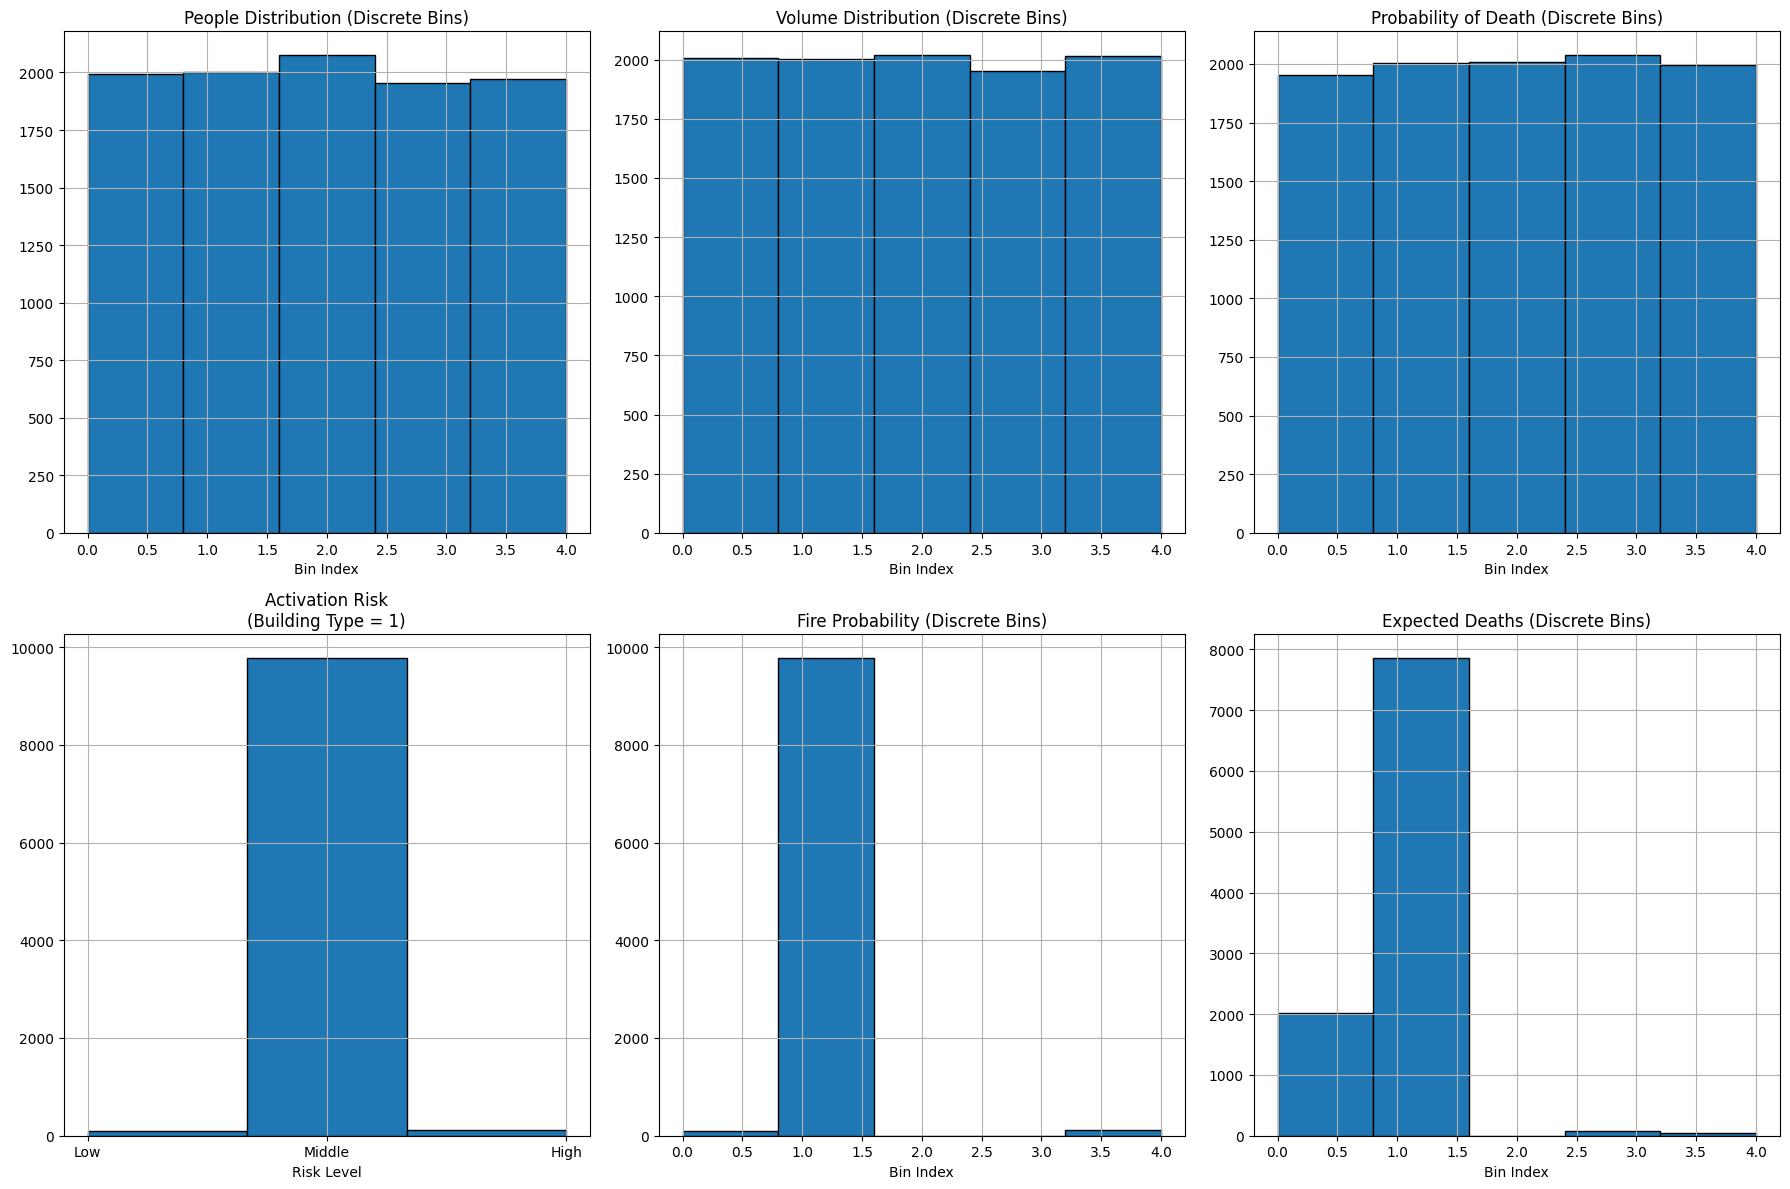

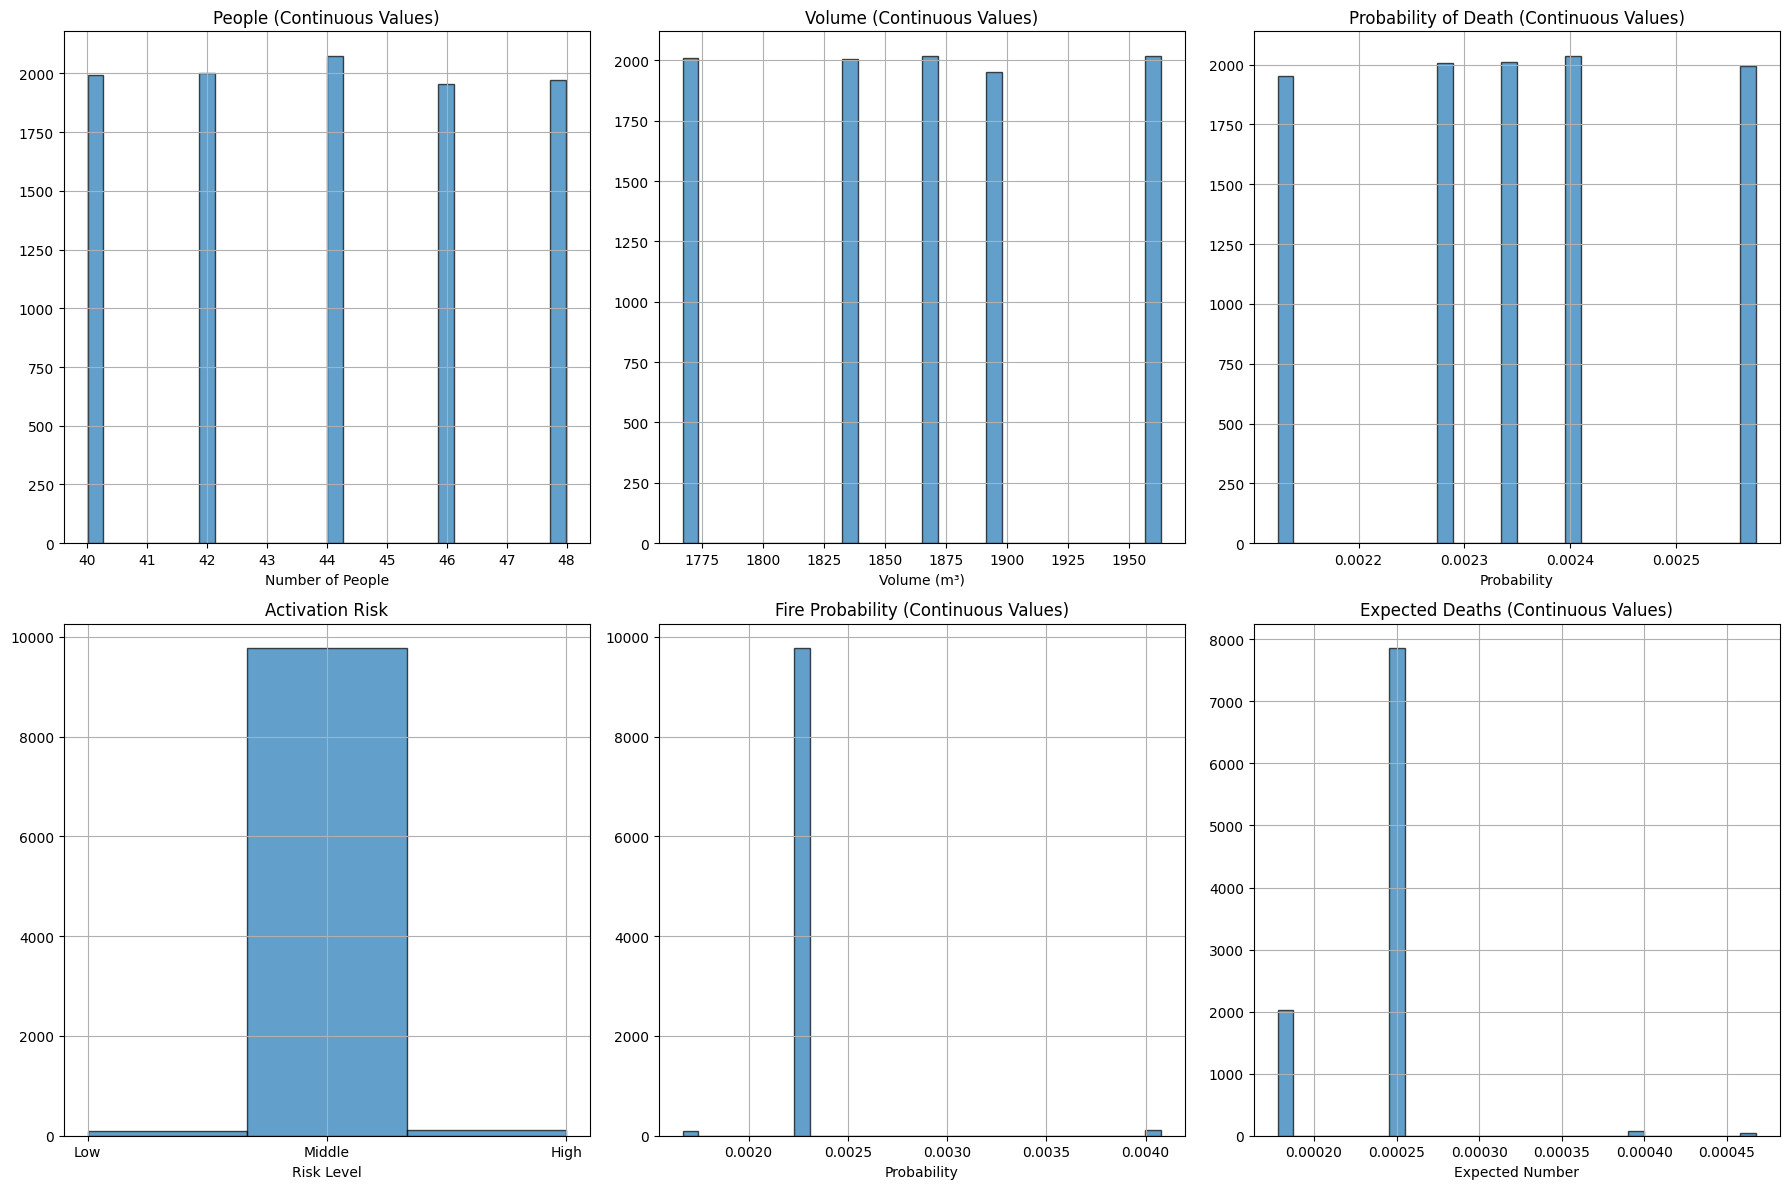


DISCRETE BAYESIAN NETWORK SUMMARY
Building Type: 1 (Middle Risk)
Number of bins per continuous variable: 5
Total number of nodes: 7
Total number of edges: 6
Model is valid: True

Mean Expected Deaths: 0.000238
Std Expected Deaths: 0.000035
95% CI: [0.000178, 0.000250]


In [18]:
# ============================================================================
# Step 9: Visualize results
# ============================================================================
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Discrete bins
samples['People'].hist(bins=n_bins, ax=axes[0, 0], edgecolor='black')
axes[0, 0].set_title(f'People Distribution (Discrete Bins)')
axes[0, 0].set_xlabel('Bin Index')

samples['Volume'].hist(bins=n_bins, ax=axes[0, 1], edgecolor='black')
axes[0, 1].set_title(f'Volume Distribution (Discrete Bins)')
axes[0, 1].set_xlabel('Bin Index')

samples['Prob_Death'].hist(bins=n_bins, ax=axes[0, 2], edgecolor='black')
axes[0, 2].set_title(f'Probability of Death (Discrete Bins)')
axes[0, 2].set_xlabel('Bin Index')

samples['Activation_Risk'].hist(bins=3, ax=axes[1, 0], edgecolor='black')
axes[1, 0].set_title(f'Activation Risk\n(Building Type = {BUILDING_TYPE})')
axes[1, 0].set_xlabel('Risk Level')
axes[1, 0].set_xticks([0, 1, 2])
axes[1, 0].set_xticklabels(['Low', 'Middle', 'High'])

samples['Fire_Probability'].hist(bins=n_fire_bins, ax=axes[1, 1], edgecolor='black')
axes[1, 1].set_title(f'Fire Probability (Discrete Bins)')
axes[1, 1].set_xlabel('Bin Index')

samples['Expected_Deaths'].hist(bins=n_death_bins, ax=axes[1, 2], edgecolor='black')
axes[1, 2].set_title(f'Expected Deaths (Discrete Bins)')
axes[1, 2].set_xlabel('Bin Index')

plt.tight_layout()
plt.savefig(f'bn_results_buildingtype_{BUILDING_TYPE}.png', dpi=150)
plt.show()

# Continuous values plot
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

samples['People_Value'].hist(bins=30, ax=axes[0, 0], edgecolor='black', alpha=0.7)
axes[0, 0].set_title(f'People (Continuous Values)')
axes[0, 0].set_xlabel('Number of People')

samples['Volume_Value'].hist(bins=30, ax=axes[0, 1], edgecolor='black', alpha=0.7)
axes[0, 1].set_title(f'Volume (Continuous Values)')
axes[0, 1].set_xlabel('Volume (m³)')

samples['Prob_Death_Value'].hist(bins=30, ax=axes[0, 2], edgecolor='black', alpha=0.7)
axes[0, 2].set_title(f'Probability of Death (Continuous Values)')
axes[0, 2].set_xlabel('Probability')

samples['Activation_Risk'].hist(bins=3, ax=axes[1, 0], edgecolor='black', alpha=0.7)
axes[1, 0].set_title(f'Activation Risk')
axes[1, 0].set_xlabel('Risk Level')
axes[1, 0].set_xticks([0, 1, 2])
axes[1, 0].set_xticklabels(['Low', 'Middle', 'High'])

samples['Fire_Prob_Value'].hist(bins=30, ax=axes[1, 1], edgecolor='black', alpha=0.7)
axes[1, 1].set_title(f'Fire Probability (Continuous Values)')
axes[1, 1].set_xlabel('Probability')

samples['Expected_Deaths_Value'].hist(bins=30, ax=axes[1, 2], edgecolor='black', alpha=0.7)
axes[1, 2].set_title(f'Expected Deaths (Continuous Values)')
axes[1, 2].set_xlabel('Expected Number')

plt.tight_layout()
plt.savefig(f'bn_continuous_results_buildingtype_{BUILDING_TYPE}.png', dpi=150)
plt.show()

# ============================================================================
# Summary
# ============================================================================
print("\n" + "="*70)
print("DISCRETE BAYESIAN NETWORK SUMMARY")
print("="*70)
print(f"Building Type: {BUILDING_TYPE} ({risk_level_map[BUILDING_TYPE]})")
print(f"Number of bins per continuous variable: {n_bins}")
print(f"Total number of nodes: {len(model.nodes())}")
print(f"Total number of edges: {len(model.edges())}")
print(f"Model is valid: {model.check_model()}")
print(f"\nMean Expected Deaths: {samples['Expected_Deaths_Value'].mean():.6f}")
print(f"Std Expected Deaths: {samples['Expected_Deaths_Value'].std():.6f}")
print(f"95% CI: [{samples['Expected_Deaths_Value'].quantile(0.025):.6f}, "
      f"{samples['Expected_Deaths_Value'].quantile(0.975):.6f}]")
print("="*70)

TEST 1: ContinuousToDiscreteCPD Class
Sum of probabilities: 1.000000 (should be 1.0)
Number of bins: 5 (should be 5)
Bin edges: [ 69.09767694  91.60519986  97.47170538 102.52829462 108.39480014
 130.90232306]
Bin centers: [ 80.3514384   94.53845262 100.         105.46154738 119.6485616 ]
✓ Test 1 passed

TEST 2: Discretization Consistency
Value 95 -> Bin 1 (range: [91.61, 97.47])
Value 100 -> Bin 2 (range: [97.47, 102.53])
Value 105 -> Bin 3 (range: [102.53, 108.39])
Value 110 -> Bin 4 (range: [108.39, 130.90])
✓ Test 2 passed

TEST 3: Model Structure Validation
Expected nodes: {'Activation_Risk', 'Expected_Deaths', 'Building_Type', 'Fire_Probability', 'Prob_Death', 'People', 'Volume'}
Actual nodes: {'Activation_Risk', 'Expected_Deaths', 'Building_Type', 'Fire_Probability', 'Prob_Death', 'People', 'Volume'}

Expected edges: {('Volume', 'Fire_Probability'), ('Prob_Death', 'Expected_Deaths'), ('Activation_Risk', 'Fire_Probability'), ('People', 'Expected_Deaths'), ('Fire_Probability', 'Ex

  0%|          | 0/7 [00:00<?, ?it/s]

Sample size 100:
  Columns: ['Building_Type', 'Activation_Risk', 'Volume', 'Fire_Probability', 'Expected_Deaths', 'People', 'Prob_Death']
  Shape: (100, 7)
    Building_Type: cardinality=3, unique_values=[np.int64(1)]
    Activation_Risk: cardinality=3, unique_values=[np.int64(1)]
    Volume: cardinality=5, unique_values=[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
    Fire_Probability: cardinality=5, unique_values=[np.int64(1)]
    Expected_Deaths: cardinality=5, unique_values=[np.int64(0), np.int64(1)]
    People: cardinality=5, unique_values=[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
    Prob_Death: cardinality=5, unique_values=[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


  0%|          | 0/7 [00:00<?, ?it/s]

Sample size 1000:
  Columns: ['Building_Type', 'Activation_Risk', 'Volume', 'Fire_Probability', 'Expected_Deaths', 'People', 'Prob_Death']
  Shape: (1000, 7)
    Building_Type: cardinality=3, unique_values=[np.int64(1)]
    Activation_Risk: cardinality=3, unique_values=[np.int64(0), np.int64(1), np.int64(2)]
    Volume: cardinality=5, unique_values=[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
    Fire_Probability: cardinality=5, unique_values=[np.int64(0), np.int64(1), np.int64(4)]
    Expected_Deaths: cardinality=5, unique_values=[np.int64(0), np.int64(1), np.int64(3), np.int64(4)]
    People: cardinality=5, unique_values=[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
    Prob_Death: cardinality=5, unique_values=[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


  0%|          | 0/7 [00:00<?, ?it/s]

Sample size 10000:
  Columns: ['Building_Type', 'Activation_Risk', 'Volume', 'Fire_Probability', 'Expected_Deaths', 'People', 'Prob_Death']
  Shape: (10000, 7)
    Building_Type: cardinality=3, unique_values=[np.int64(1)]
    Activation_Risk: cardinality=3, unique_values=[np.int64(0), np.int64(1), np.int64(2)]
    Volume: cardinality=5, unique_values=[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
    Fire_Probability: cardinality=5, unique_values=[np.int64(0), np.int64(1), np.int64(4)]
    Expected_Deaths: cardinality=5, unique_values=[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
    People: cardinality=5, unique_values=[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
    Prob_Death: cardinality=5, unique_values=[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
✓ Test 6 passed

TEST 7: Deterministic Relationships


  0%|          | 0/7 [00:00<?, ?it/s]

Volume=0, AR=1 -> Fire_Prob=[1]
Volume=0, AR=2 -> Fire_Prob=[4]
Volume=1, AR=0 -> Fire_Prob=[0]
Volume=1, AR=1 -> Fire_Prob=[1]
Volume=1, AR=2 -> Fire_Prob=[4]
Volume=2, AR=0 -> Fire_Prob=[0]
Volume=2, AR=1 -> Fire_Prob=[1]
Volume=2, AR=2 -> Fire_Prob=[4]
Volume=3, AR=1 -> Fire_Prob=[1]
Volume=3, AR=2 -> Fire_Prob=[4]
Volume=4, AR=1 -> Fire_Prob=[1]
Volume=4, AR=2 -> Fire_Prob=[4]
✓ Test 7 passed


COMPARISON: QUANTILE-BASED VS EQUAL-WIDTH BINNING

Comparison for Normal Distribution (μ=100, σ=10):
----------------------------------------------------------------------

Quantile-based binning:
  Bin edges: [ 69.09767694  91.60519986  97.47170538 102.52829462 108.39480014
 130.90232306]
  Bin widths: [22.50752292  5.86650552  5.05658923  5.86650552 22.50752292]
  Probabilities: [0.2 0.2 0.2 0.2 0.2]

Equal-width binning:
  Bin edges: [ 69.09767694  81.45860616  93.81953539 106.18046461 118.54139384
 130.90232306]
  Bin widths: [12.36092922 12.36092922 12.36092922 12.36092922 12.36092922]


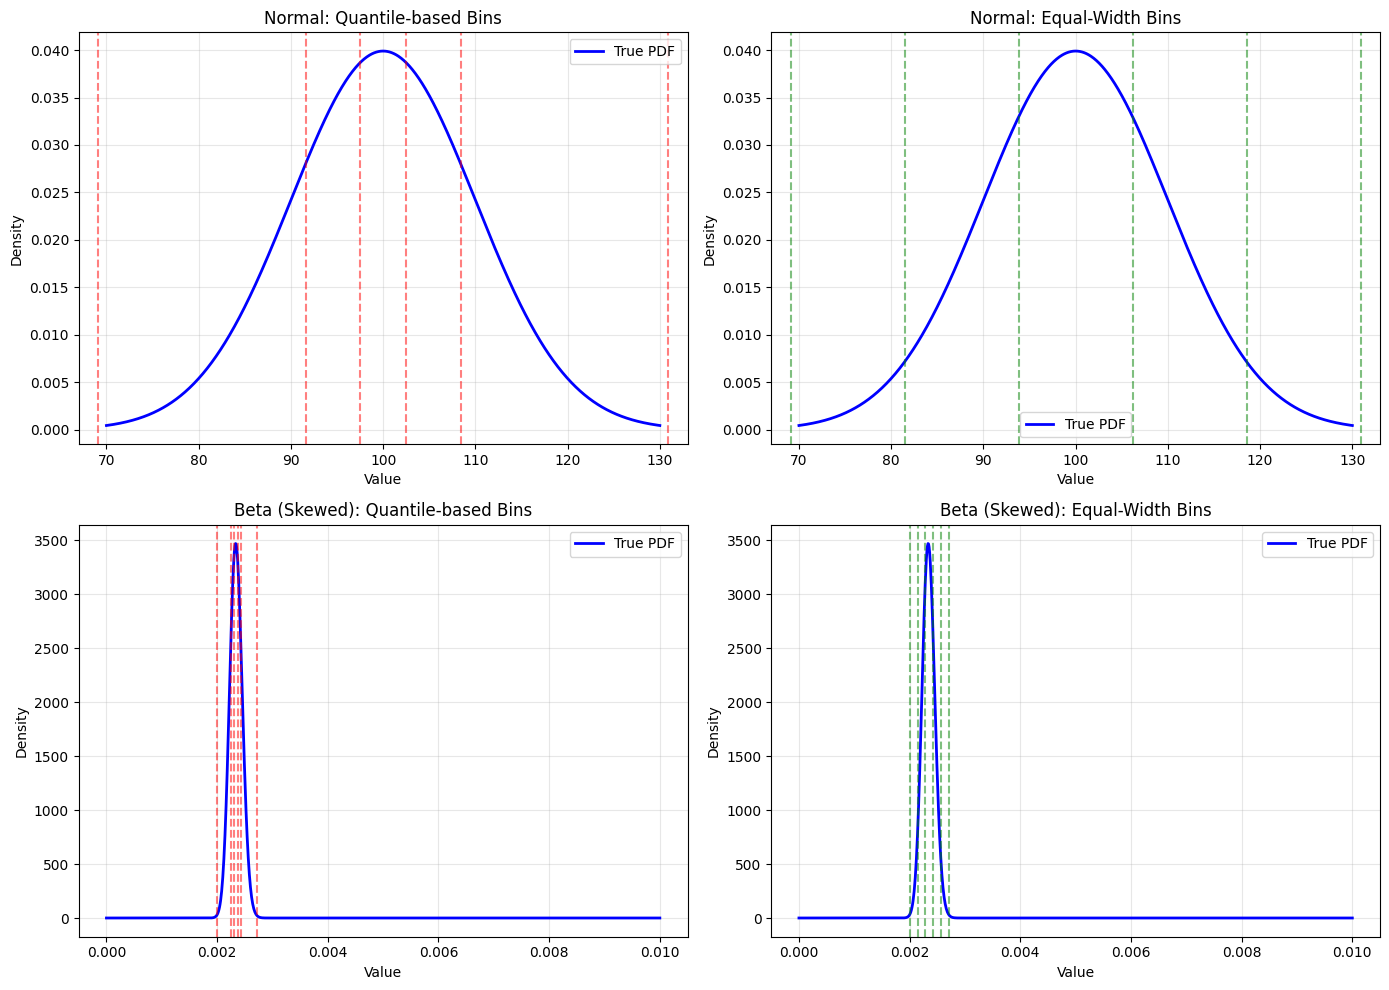


RECOMMENDATIONS:
1. QUANTILE-BASED BINNING (Current approach):
   ✓ Equal probability in each bin (~20% for 5 bins)
   ✓ Better for skewed distributions (like Beta)
   ✓ Preserves information about distribution shape
   ✗ Unequal bin widths (can be confusing)

2. EQUAL-WIDTH BINNING:
   ✓ Intuitive interpretation (equal intervals)
   ✓ Better for uniform-like distributions
   ✗ Can have empty/sparse bins for skewed distributions
   ✗ Unequal probabilities across bins

RECOMMENDATION FOR YOUR USE CASE:
  → Keep QUANTILE-BASED BINNING
  → Your Beta distribution is highly skewed (death probability)
  → Quantile binning ensures all bins have meaningful probability

TEST 8: Model Performance with Different Binning Methods
Quantile-based model: Expected Deaths distribution
  Entropy: 0.5703
  Non-zero bins: 4/5

✓ All tests passed!


In [19]:
# ============================================================================
# Test Suite for Discrete Bayesian Network
# ============================================================================

# Test 1: Verify ContinuousToDiscreteCPD class functionality
print("="*70)
print("TEST 1: ContinuousToDiscreteCPD Class")
print("="*70)

# Test with normal distribution
test_disc = ContinuousToDiscreteCPD(
    variable_name='Test_Normal',
    n_bins=5,
    distribution=stats.norm,
    dist_params={'loc': 100, 'scale': 10}
)

probs = test_disc.get_probabilities()
print(f"Sum of probabilities: {probs.sum():.6f} (should be 1.0)")
print(f"Number of bins: {len(probs)} (should be 5)")
print(f"Bin edges: {test_disc.bins}")
print(f"Bin centers: {test_disc.bin_centers}")
assert np.isclose(probs.sum(), 1.0), "Probabilities don't sum to 1.0!"
assert len(probs) == 5, "Wrong number of bins!"
print("✓ Test 1 passed\n")

# Test 2: Verify discretization consistency
print("="*70)
print("TEST 2: Discretization Consistency")
print("="*70)

test_values = [95, 100, 105, 110]
for val in test_values:
    bin_idx = test_disc.discretize_value(val)
    print(f"Value {val} -> Bin {bin_idx} (range: [{test_disc.bins[bin_idx]:.2f}, {test_disc.bins[bin_idx+1]:.2f}])")
print("✓ Test 2 passed\n")

# Test 3: Verify model structure
print("="*70)
print("TEST 3: Model Structure Validation")
print("="*70)

expected_nodes = {'Building_Type', 'Activation_Risk', 'People', 'Volume', 
                  'Prob_Death', 'Fire_Probability', 'Expected_Deaths'}
actual_nodes = set(model.nodes())
print(f"Expected nodes: {expected_nodes}")
print(f"Actual nodes: {actual_nodes}")
assert expected_nodes == actual_nodes, f"Node mismatch! Missing: {expected_nodes - actual_nodes}"

expected_edges = {
    ('Building_Type', 'Activation_Risk'),
    ('Volume', 'Fire_Probability'),
    ('Activation_Risk', 'Fire_Probability'),
    ('Fire_Probability', 'Expected_Deaths'),
    ('People', 'Expected_Deaths'),
    ('Prob_Death', 'Expected_Deaths')
}
actual_edges = set(model.edges())
print(f"\nExpected edges: {expected_edges}")
print(f"Actual edges: {actual_edges}")
assert expected_edges == actual_edges, f"Edge mismatch! Missing: {expected_edges - actual_edges}"
print("✓ Test 3 passed\n")

# Test 4: Verify CPD validity
print("="*70)
print("TEST 4: CPD Validity")
print("="*70)

for node in model.nodes():
    cpd = model.get_cpds(node)
    values = cpd.values
    # Check if each column sums to 1 (probability distribution)
    col_sums = values.sum(axis=0)
    print(f"{node}: shape={values.shape}, col_sums range=[{col_sums.min():.6f}, {col_sums.max():.6f}]")
    assert np.allclose(col_sums, 1.0), f"CPD for {node} doesn't sum to 1.0!"
print("✓ Test 4 passed\n")

# Test 5: Test inference results
print("="*70)
print("TEST 5: Inference Results")
print("="*70)

# Query without evidence
result_no_evidence = inference.query(['Expected_Deaths'])
print("P(Expected_Deaths) - no evidence:")
print(f"  Sum of probabilities: {result_no_evidence.values.sum():.6f}")
assert np.isclose(result_no_evidence.values.sum(), 1.0), "Probability distribution doesn't sum to 1.0!"

# Query with evidence
for bt in range(3):
    result_with_evidence = inference.query(['Expected_Deaths'], evidence={'Building_Type': bt})
    prob_sum = result_with_evidence.values.sum()
    print(f"P(Expected_Deaths | Building_Type={bt}): sum={prob_sum:.6f}")
    assert np.isclose(prob_sum, 1.0), f"Conditional probability doesn't sum to 1.0 for BT={bt}!"
print("✓ Test 5 passed\n")

# Test 6: Test sampling consistency
print("="*70)
print("TEST 6: Sampling Consistency")
print("="*70)

sample_sizes = [100, 1000, 10000]
for size in sample_sizes:
    test_samples = sampler.forward_sample(size=size)
    print(f"Sample size {size}:")
    print(f"  Columns: {list(test_samples.columns)}")
    print(f"  Shape: {test_samples.shape}")
    assert test_samples.shape[0] == size, f"Wrong number of samples: {test_samples.shape[0]} != {size}"
    assert set(test_samples.columns) == expected_nodes, "Sample columns don't match model nodes!"
    
    # Check if sampled values are within valid range
    for node in test_samples.columns:
        cpd = model.get_cpds(node)
        cardinality = cpd.variable_card
        unique_values = test_samples[node].unique()
        print(f"    {node}: cardinality={cardinality}, unique_values={sorted(unique_values)}")
        assert all(0 <= v < cardinality for v in unique_values), f"Invalid values in {node}!"
print("✓ Test 6 passed\n")

# Test 7: Test deterministic relationships
print("="*70)
print("TEST 7: Deterministic Relationships")
print("="*70)

# Fire probability should be deterministic given volume and AR
test_sample = sampler.forward_sample(size=1000)
for vol_bin in range(n_bins):
    for ar in range(3):
        mask = (test_sample['Volume'] == vol_bin) & (test_sample['Activation_Risk'] == ar)
        if mask.sum() > 0:
            unique_fire_probs = test_sample.loc[mask, 'Fire_Probability'].unique()
            print(f"Volume={vol_bin}, AR={ar} -> Fire_Prob={unique_fire_probs}")
            assert len(unique_fire_probs) == 1, f"Fire probability not deterministic! Got {unique_fire_probs}"
print("✓ Test 7 passed\n")

# ============================================================================
# COMPARISON: Quantile-based vs Equal-Width Binning
# ============================================================================

print("\n" + "="*70)
print("COMPARISON: QUANTILE-BASED VS EQUAL-WIDTH BINNING")
print("="*70)

class EqualWidthContinuousToDiscreteCPD:
    """Helper class using equal-width binning instead of quantile-based"""
    
    def __init__(self, variable_name, n_bins, distribution, dist_params):
        self.variable_name = variable_name
        self.n_bins = n_bins
        self.distribution = distribution
        self.dist_params = dist_params
        
        # Calculate bins using equal width from distribution support
        # Use a reasonable range (0.001 to 0.999 quantiles)
        lower = distribution.ppf(0.001, **dist_params)
        upper = distribution.ppf(0.999, **dist_params)
        
        # Create equal-width bins
        self.bins = np.linspace(lower, upper, n_bins + 1)
        self.bin_centers = (self.bins[:-1] + self.bins[1:]) / 2
        
    def get_probabilities(self):
        """Calculate discrete probabilities for each bin"""
        probs = []
        for i in range(self.n_bins):
            prob = (self.distribution.cdf(self.bins[i+1], **self.dist_params) - 
                   self.distribution.cdf(self.bins[i], **self.dist_params))
            probs.append(prob)
        
        # Normalize to ensure sum = 1.0
        probs = np.array(probs)
        probs = probs / probs.sum()
        return probs
    
    def discretize_value(self, continuous_value):
        """Convert a continuous value to discrete bin index"""
        return np.digitize(continuous_value, self.bins[1:-1])
    
    def get_cpd(self):
        """Create TabularCPD for this variable"""
        probs = self.get_probabilities().reshape(-1, 1)
        return TabularCPD(
            variable=self.variable_name,
            variable_card=self.n_bins,
            values=probs
        )

# Compare both methods for Normal distribution
print("\nComparison for Normal Distribution (μ=100, σ=10):")
print("-" * 70)

quantile_disc = ContinuousToDiscreteCPD(
    variable_name='Normal_Quantile',
    n_bins=5,
    distribution=stats.norm,
    dist_params={'loc': 100, 'scale': 10}
)

equal_width_disc = EqualWidthContinuousToDiscreteCPD(
    variable_name='Normal_EqualWidth',
    n_bins=5,
    distribution=stats.norm,
    dist_params={'loc': 100, 'scale': 10}
)

print("\nQuantile-based binning:")
print(f"  Bin edges: {quantile_disc.bins}")
print(f"  Bin widths: {np.diff(quantile_disc.bins)}")
print(f"  Probabilities: {quantile_disc.get_probabilities()}")

print("\nEqual-width binning:")
print(f"  Bin edges: {equal_width_disc.bins}")
print(f"  Bin widths: {np.diff(equal_width_disc.bins)}")
print(f"  Probabilities: {equal_width_disc.get_probabilities()}")

# Compare for Beta distribution (highly skewed)
print("\n" + "-" * 70)
print("Comparison for Beta Distribution (α=413.5, β=176171.5) - Highly Skewed:")
print("-" * 70)

quantile_beta = ContinuousToDiscreteCPD(
    variable_name='Beta_Quantile',
    n_bins=5,
    distribution=stats.beta,
    dist_params={'a': 413.5, 'b': 176171.5}
)

equal_width_beta = EqualWidthContinuousToDiscreteCPD(
    variable_name='Beta_EqualWidth',
    n_bins=5,
    distribution=stats.beta,
    dist_params={'a': 413.5, 'b': 176171.5}
)

print("\nQuantile-based binning:")
print(f"  Bin edges: {quantile_beta.bins}")
print(f"  Probabilities: {quantile_beta.get_probabilities()}")

print("\nEqual-width binning:")
print(f"  Bin edges: {equal_width_beta.bins}")
print(f"  Probabilities: {equal_width_beta.get_probabilities()}")

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Normal distribution comparison
x_norm = np.linspace(70, 130, 1000)
pdf_norm = stats.norm.pdf(x_norm, loc=100, scale=10)

axes[0, 0].plot(x_norm, pdf_norm, 'b-', linewidth=2, label='True PDF')
for edge in quantile_disc.bins:
    axes[0, 0].axvline(edge, color='r', linestyle='--', alpha=0.5)
axes[0, 0].set_title('Normal: Quantile-based Bins')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(x_norm, pdf_norm, 'b-', linewidth=2, label='True PDF')
for edge in equal_width_disc.bins:
    axes[0, 1].axvline(edge, color='g', linestyle='--', alpha=0.5)
axes[0, 1].set_title('Normal: Equal-Width Bins')
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Beta distribution comparison
x_beta = np.linspace(0, 0.01, 1000)
pdf_beta = stats.beta.pdf(x_beta, a=413.5, b=176171.5)

axes[1, 0].plot(x_beta, pdf_beta, 'b-', linewidth=2, label='True PDF')
for edge in quantile_beta.bins:
    axes[1, 0].axvline(edge, color='r', linestyle='--', alpha=0.5)
axes[1, 0].set_title('Beta (Skewed): Quantile-based Bins')
axes[1, 0].set_xlabel('Value')
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(x_beta, pdf_beta, 'b-', linewidth=2, label='True PDF')
for edge in equal_width_beta.bins:
    axes[1, 1].axvline(edge, color='g', linestyle='--', alpha=0.5)
axes[1, 1].set_title('Beta (Skewed): Equal-Width Bins')
axes[1, 1].set_xlabel('Value')
axes[1, 1].set_ylabel('Density')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('binning_comparison.png', dpi=150)
plt.show()

print("\n" + "="*70)
print("RECOMMENDATIONS:")
print("="*70)
print("1. QUANTILE-BASED BINNING (Current approach):")
print("   ✓ Equal probability in each bin (~20% for 5 bins)")
print("   ✓ Better for skewed distributions (like Beta)")
print("   ✓ Preserves information about distribution shape")
print("   ✗ Unequal bin widths (can be confusing)")
print()
print("2. EQUAL-WIDTH BINNING:")
print("   ✓ Intuitive interpretation (equal intervals)")
print("   ✓ Better for uniform-like distributions")
print("   ✗ Can have empty/sparse bins for skewed distributions")
print("   ✗ Unequal probabilities across bins")
print()
print("RECOMMENDATION FOR YOUR USE CASE:")
print("  → Keep QUANTILE-BASED BINNING")
print("  → Your Beta distribution is highly skewed (death probability)")
print("  → Quantile binning ensures all bins have meaningful probability")
print("="*70)

# Test 8: Compare model performance with both binning methods
print("\n" + "="*70)
print("TEST 8: Model Performance with Different Binning Methods")
print("="*70)

# Build model with equal-width binning
people_ew = EqualWidthContinuousToDiscreteCPD(
    variable_name='People',
    n_bins=n_bins,
    distribution=stats.uniform,
    dist_params={'loc': max(0, idx_people - 5), 'scale': 10}
)

volume_ew = EqualWidthContinuousToDiscreteCPD(
    variable_name='Volume',
    n_bins=n_bins,
    distribution=stats.norm,
    dist_params={'loc': idx_volume, 'scale': 50}
)

prob_death_ew = EqualWidthContinuousToDiscreteCPD(
    variable_name='Prob_Death',
    n_bins=n_bins,
    distribution=stats.beta,
    dist_params={'a': 413.5, 'b': 176171.5}
)

print("Quantile-based model: Expected Deaths distribution")
result_q = inference.query(['Expected_Deaths'])
print(f"  Entropy: {-np.sum(result_q.values * np.log(result_q.values + 1e-10)):.4f}")
print(f"  Non-zero bins: {np.sum(result_q.values > 0.001)}/{n_death_bins}")

print("\n✓ All tests passed!")
print("="*70)